# Triple SMA crossover strategy 

In this code I will develop a triple SMA crossover strategy (long/short), which is a momentum strategy based on one technical indicator with 3 different lengths.

Topics:
1) Data collection (optional)

2) Backtests

3) Comparison with "buy and hold" strategy

4) input optimization

5) Implementation of the strategy using Binance API

## 1) Data collection

Here I go through the process of historical data collection, 
sorting and processing. The purpose of this is to later use the data for backtesting the strategy.

By default I will be using one-hour data for the pair BTCUSDT (bitcoin/tether), starting from 17th August 2017 (the earliest available historical price data for this pair on Binance)


### This section can be skipped as pulling the most recent data can take a lot of time; if you decide to do so, please access the prepared data here:

https://drive.google.com/file/d/1oaknCI-uqwXMF3YowA7u5I89Y4KIhmIO/view?usp=sharing

and use the code below to load the dataframe

In [ ]:
data = pd.read_csv("bitcoin.csv", parse_dates = ["Date"], index_col = "Date")
data = data[["Close"]].copy()
data


### ------------------------------------------------------------------------


In [1]:
from binance.client import Client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from itertools import product
import warnings
warnings.filterwarnings("ignore")
plt.style.use("seaborn")
from binance.client import Client
from binance import ThreadedWebsocketManager
from datetime import datetime, timedelta
import time

In [ ]:
api_key = "insert_here"
secret_key = "insert_here"

In [3]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com")

To test the strategy I will be using the earliest available historical data on BTCUSDT trading pair

In [4]:
timestamp = client._get_earliest_valid_timestamp(symbol = "BTCUSDT", interval = "1d")
timestamp

1502928000000

In [5]:
pd.to_datetime(timestamp, unit = "ms") # earliest data available on Binance

Timestamp('2017-08-17 00:00:00')

In [7]:
bars = client.get_historical_klines(symbol = "BTCUSDT",
                                    interval = "1h", start_str = timestamp, limit = 1000)
bars

[[1502942400000,
  '4261.48000000',
  '4313.62000000',
  '4261.32000000',
  '4308.83000000',
  '47.18100900',
  1502945999999,
  '202366.13839304',
  171,
  '35.16050300',
  '150952.47794304',
  '7887.63551305'],
 [1502946000000,
  '4308.83000000',
  '4328.69000000',
  '4291.37000000',
  '4315.32000000',
  '23.23491600',
  1502949599999,
  '100304.82356749',
  102,
  '21.44807100',
  '92608.27972836',
  '8039.26240152'],
 [1502949600000,
  '4330.29000000',
  '4345.45000000',
  '4309.37000000',
  '4324.35000000',
  '7.22969100',
  1502953199999,
  '31282.31266989',
  36,
  '4.80286100',
  '20795.31722405',
  '8041.76049845'],
 [1502953200000,
  '4316.62000000',
  '4349.99000000',
  '4287.41000000',
  '4349.99000000',
  '4.44324900',
  1502956799999,
  '19241.05829986',
  25,
  '2.60229200',
  '11291.34701534',
  '8048.12788573'],
 [1502956800000,
  '4333.32000000',
  '4377.85000000',
  '4333.32000000',
  '4360.69000000',
  '0.97280700',
  1502960399999,
  '4239.50358563',
  28,
  '0.814

In [8]:
df = pd.DataFrame(bars)
df #converting strings to pandas data frame

,0,1,2,3,4,5,6,7,8,9,10,11
0,1502942400000,4261.48000000,4313.62000000,4261.32000000,4308.83000000,47.18100900,1502945999999,202366.13839304,171,35.16050300,150952.47794304,7887.63551305
1,1502946000000,4308.83000000,4328.69000000,4291.37000000,4315.32000000,23.23491600,1502949599999,100304.82356749,102,21.44807100,92608.27972836,8039.26240152
2,1502949600000,4330.29000000,4345.45000000,4309.37000000,4324.35000000,7.22969100,1502953199999,31282.31266989,36,4.80286100,20795.31722405,8041.76049845
3,1502953200000,4316.62000000,4349.99000000,4287.41000000,4349.99000000,4.44324900,1502956799999,19241.05829986,25,2.60229200,11291.34701534,8048.12788573
4,1502956800000,4333.32000000,4377.85000000,4333.32000000,4360.69000000,0.97280700,1502960399999,4239.50358563,28,0.81465500,3552.74681715,8018.03650010
...,...,...,...,...,...,...,...,...,...,...,...,...
41085,1651302000000,38701.11000000,38746.15000000,38634.24000000,38650.34000000,867.42132000,1651305599999,33555779.29705060,32798,446.77611000,17283507.13277340,0
41086,1651305600000,38650.35000000,38688.72000000,38536.66000000,38577.06000000,1542.29491000,1651309199999,59555411.68907000,45935,661.41676000,25539479.25296980,0
41087,1651309200000,38577.07000000,38644.03000000,38540.98000000,38622.50000000,881.80886000,1651312799999,34034531.99406800,41209,416.72999000,16082922.58051480,0
41088,1651312800000,38622.51000000,38658.72000000,38564.46000000,38566.49000000,804.52260000,1651316399999,31061049.80119040,39497,412.95047000,15942686.42089250,0


In [9]:
df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
df

,0,1,2,3,4,5,6,7,8,9,10,11,Date
0,1502942400000,4261.48000000,4313.62000000,4261.32000000,4308.83000000,47.18100900,1502945999999,202366.13839304,171,35.16050300,150952.47794304,7887.63551305,2017-08-17 04:00:00
1,1502946000000,4308.83000000,4328.69000000,4291.37000000,4315.32000000,23.23491600,1502949599999,100304.82356749,102,21.44807100,92608.27972836,8039.26240152,2017-08-17 05:00:00
2,1502949600000,4330.29000000,4345.45000000,4309.37000000,4324.35000000,7.22969100,1502953199999,31282.31266989,36,4.80286100,20795.31722405,8041.76049845,2017-08-17 06:00:00
3,1502953200000,4316.62000000,4349.99000000,4287.41000000,4349.99000000,4.44324900,1502956799999,19241.05829986,25,2.60229200,11291.34701534,8048.12788573,2017-08-17 07:00:00
4,1502956800000,4333.32000000,4377.85000000,4333.32000000,4360.69000000,0.97280700,1502960399999,4239.50358563,28,0.81465500,3552.74681715,8018.03650010,2017-08-17 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41085,1651302000000,38701.11000000,38746.15000000,38634.24000000,38650.34000000,867.42132000,1651305599999,33555779.29705060,32798,446.77611000,17283507.13277340,0,2022-04-30 07:00:00
41086,1651305600000,38650.35000000,38688.72000000,38536.66000000,38577.06000000,1542.29491000,1651309199999,59555411.68907000,45935,661.41676000,25539479.25296980,0,2022-04-30 08:00:00
41087,1651309200000,38577.07000000,38644.03000000,38540.98000000,38622.50000000,881.80886000,1651312799999,34034531.99406800,41209,416.72999000,16082922.58051480,0,2022-04-30 09:00:00
41088,1651312800000,38622.51000000,38658.72000000,38564.46000000,38566.49000000,804.52260000,1651316399999,31061049.80119040,39497,412.95047000,15942686.42089250,0,2022-04-30 10:00:00


In [10]:
df.columns = ["Open Time", "Open", "High", "Low", "Close",
              "Volume", "Clos Time", "Quote Asset Volume", 
              "Number of Trades", "Taker Buy Base Asset Volume",
              "Taker Buy Quote Asset Volume", "Ignore", "Date" ]
df

,Open Time,Open,High,Low,Close,Volume,Clos Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore,Date
0,1502942400000,4261.48000000,4313.62000000,4261.32000000,4308.83000000,47.18100900,1502945999999,202366.13839304,171,35.16050300,150952.47794304,7887.63551305,2017-08-17 04:00:00
1,1502946000000,4308.83000000,4328.69000000,4291.37000000,4315.32000000,23.23491600,1502949599999,100304.82356749,102,21.44807100,92608.27972836,8039.26240152,2017-08-17 05:00:00
2,1502949600000,4330.29000000,4345.45000000,4309.37000000,4324.35000000,7.22969100,1502953199999,31282.31266989,36,4.80286100,20795.31722405,8041.76049845,2017-08-17 06:00:00
3,1502953200000,4316.62000000,4349.99000000,4287.41000000,4349.99000000,4.44324900,1502956799999,19241.05829986,25,2.60229200,11291.34701534,8048.12788573,2017-08-17 07:00:00
4,1502956800000,4333.32000000,4377.85000000,4333.32000000,4360.69000000,0.97280700,1502960399999,4239.50358563,28,0.81465500,3552.74681715,8018.03650010,2017-08-17 08:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41085,1651302000000,38701.11000000,38746.15000000,38634.24000000,38650.34000000,867.42132000,1651305599999,33555779.29705060,32798,446.77611000,17283507.13277340,0,2022-04-30 07:00:00
41086,1651305600000,38650.35000000,38688.72000000,38536.66000000,38577.06000000,1542.29491000,1651309199999,59555411.68907000,45935,661.41676000,25539479.25296980,0,2022-04-30 08:00:00
41087,1651309200000,38577.07000000,38644.03000000,38540.98000000,38622.50000000,881.80886000,1651312799999,34034531.99406800,41209,416.72999000,16082922.58051480,0,2022-04-30 09:00:00
41088,1651312800000,38622.51000000,38658.72000000,38564.46000000,38566.49000000,804.52260000,1651316399999,31061049.80119040,39497,412.95047000,15942686.42089250,0,2022-04-30 10:00:00


In [11]:
df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
df #selecting relevant columns

,Date,Open,High,Low,Close,Volume
0,2017-08-17 04:00:00,4261.48000000,4313.62000000,4261.32000000,4308.83000000,47.18100900
1,2017-08-17 05:00:00,4308.83000000,4328.69000000,4291.37000000,4315.32000000,23.23491600
2,2017-08-17 06:00:00,4330.29000000,4345.45000000,4309.37000000,4324.35000000,7.22969100
3,2017-08-17 07:00:00,4316.62000000,4349.99000000,4287.41000000,4349.99000000,4.44324900
4,2017-08-17 08:00:00,4333.32000000,4377.85000000,4333.32000000,4360.69000000,0.97280700
...,...,...,...,...,...,...
41085,2022-04-30 07:00:00,38701.11000000,38746.15000000,38634.24000000,38650.34000000,867.42132000
41086,2022-04-30 08:00:00,38650.35000000,38688.72000000,38536.66000000,38577.06000000,1542.29491000
41087,2022-04-30 09:00:00,38577.07000000,38644.03000000,38540.98000000,38622.50000000,881.80886000
41088,2022-04-30 10:00:00,38622.51000000,38658.72000000,38564.46000000,38566.49000000,804.52260000


In [12]:
df.set_index("Date", inplace = True)
df

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48000000,4313.62000000,4261.32000000,4308.83000000,47.18100900
2017-08-17 05:00:00,4308.83000000,4328.69000000,4291.37000000,4315.32000000,23.23491600
2017-08-17 06:00:00,4330.29000000,4345.45000000,4309.37000000,4324.35000000,7.22969100
2017-08-17 07:00:00,4316.62000000,4349.99000000,4287.41000000,4349.99000000,4.44324900
2017-08-17 08:00:00,4333.32000000,4377.85000000,4333.32000000,4360.69000000,0.97280700
...,...,...,...,...,...
2022-04-30 07:00:00,38701.11000000,38746.15000000,38634.24000000,38650.34000000,867.42132000
2022-04-30 08:00:00,38650.35000000,38688.72000000,38536.66000000,38577.06000000,1542.29491000
2022-04-30 09:00:00,38577.07000000,38644.03000000,38540.98000000,38622.50000000,881.80886000


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41090 entries, 2017-08-17 04:00:00 to 2022-04-30 11:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Open    41090 non-null  object
 1   High    41090 non-null  object
 2   Low     41090 non-null  object
 3   Close   41090 non-null  object
 4   Volume  41090 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


In [14]:
for column in df.columns:
    df[column] = pd.to_numeric(df[column], errors = "coerce")
#converting data type to float64

In [15]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2022-04-30 07:00:00,38701.11,38746.15,38634.24,38650.34,867.421320
2022-04-30 08:00:00,38650.35,38688.72,38536.66,38577.06,1542.294910
2022-04-30 09:00:00,38577.07,38644.03,38540.98,38622.50,881.808860


#### Everything compressed in 1 function

In [64]:
def get_history(symbol, interval, start, end = None):
    bars = client.get_historical_klines(symbol = symbol, interval = interval,
                                        start_str = start, end_str = end, limit = 1000)
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                  "Clos Time", "Quote Asset Volume", "Number of Trades",
                  "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace = True)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors = "coerce")
    
    return df

In [65]:
df = get_history(symbol = "BTCUSDT", interval = "1h", start = timestamp)
df

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2022-04-29 20:00:00,38331.55,38584.00,38310.90,38564.44,1993.049330
2022-04-29 21:00:00,38564.38,38649.99,38450.47,38560.15,795.698300
2022-04-29 22:00:00,38560.14,38635.29,38430.03,38608.63,658.466520


In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41079 entries, 2017-08-17 04:00:00 to 2022-04-30 00:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    41079 non-null  float64
 1   High    41079 non-null  float64
 2   Low     41079 non-null  float64
 3   Close   41079 non-null  float64
 4   Volume  41079 non-null  float64
dtypes: float64(5)
memory usage: 1.9 MB


In [56]:
df.to_csv('Bitcoin.csv') #save the dataframe as .csv file in your directory

In [36]:
data = df
data = data[["Close"]].copy()

### If you decided to skip the data gathering part, please return from here

In [37]:
data["returns"] = np.log(data.Close.div(data.Close.shift(1)))
data #adding 'returns' column with log return data

,Close,returns
Date,,
2017-08-17 04:00:00,4308.83,NaN
2017-08-17 05:00:00,4315.32,0.001505
2017-08-17 06:00:00,4324.35,0.002090
2017-08-17 07:00:00,4349.99,0.005912
2017-08-17 08:00:00,4360.69,0.002457
...,...,...
2022-04-30 07:00:00,38650.34,-0.001313
2022-04-30 08:00:00,38577.06,-0.001898
2022-04-30 09:00:00,38622.50,0.001177


## 2) The triple SMA crossover strategy

The triple SMA crossover strategy is based on 1 technical indicator - the moving average with 3 different lengths. Moreover a buy signal is generated when a smaller(faster) moving average crosses above an intermediate moving average which in turn crosses above a larger(slower) moving average.

At first I will test 3 random legth moving averages with size: sma_s < sma_m < sma_l

The model has 2 conditions:
    condition1 = (sma_s > sma_m) & (sma_m > sma_l) -> GO LONG (buy)
    condition2 = (sma_s < sma_m) & (sma_m < sma_l) -> GO SHORT (sell)

In [38]:
SMA_S = 15
SMA_M = 50
SMA_L = 200

In [39]:
data["SMA_S"] = data.Close.rolling(window = SMA_S).mean()
data["SMA_M"] = data.Close.rolling(window = SMA_M).mean()
data["SMA_L"] = data.Close.rolling(window = SMA_L).mean()

data
#creating the moving averages and adding them to the data frame

,Close,returns,SMA_S,SMA_M,SMA_L
Date,,,,,
2017-08-17 04:00:00,4308.83,NaN,NaN,NaN,NaN
2017-08-17 05:00:00,4315.32,0.001505,NaN,NaN,NaN
2017-08-17 06:00:00,4324.35,0.002090,NaN,NaN,NaN
2017-08-17 07:00:00,4349.99,0.005912,NaN,NaN,NaN
2017-08-17 08:00:00,4360.69,0.002457,NaN,NaN,NaN
...,...,...,...,...,...
2022-04-30 07:00:00,38650.34,-0.001313,38609.687333,39225.2908,39436.75985
2022-04-30 08:00:00,38577.06,-0.001898,38605.342000,39208.5230,39427.50900
2022-04-30 09:00:00,38622.50,0.001177,38610.634667,39193.2728,39418.11540


In [40]:
data.dropna(inplace = True)
smas = ["SMA_S", "SMA_M", "SMA_L"]
smas

['SMA_S', 'SMA_M', 'SMA_L']

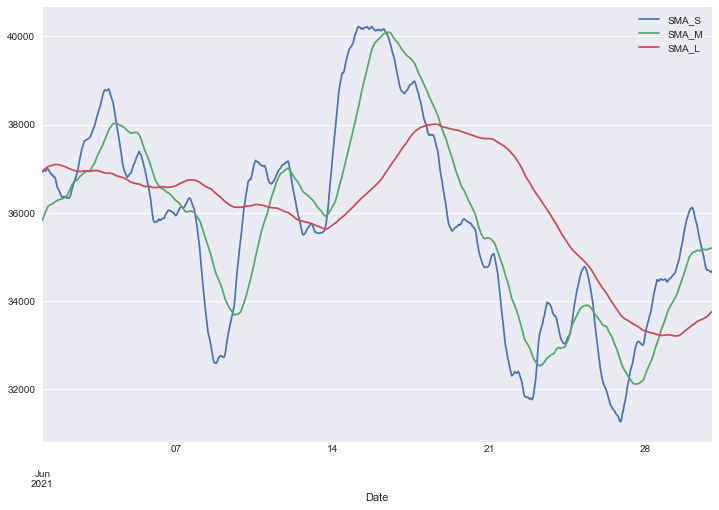

In [41]:
data.loc["2021-06", smas].plot(figsize = (12, 8))
plt.show()
#visualising the SMA's

In [42]:
data["position"] = 0 
data
#trading position -> neutral for all bars

,Close,returns,SMA_S,SMA_M,SMA_L,position
Date,,,,,,
2017-08-25 11:00:00,4361.27,0.010821,4319.996000,4214.2724,4132.71175,0
2017-08-25 12:00:00,4309.69,-0.011897,4326.842000,4215.9058,4132.71605,0
2017-08-25 13:00:00,4312.00,0.000536,4325.893333,4217.3860,4132.69945,0
2017-08-25 14:00:00,4305.00,-0.001625,4325.159333,4219.1724,4132.60270,0
2017-08-25 15:00:00,4394.36,0.020545,4327.050000,4222.8396,4132.82455,0
...,...,...,...,...,...,...
2022-04-30 07:00:00,38650.34,-0.001313,38609.687333,39225.2908,39436.75985,0
2022-04-30 08:00:00,38577.06,-0.001898,38605.342000,39208.5230,39427.50900,0
2022-04-30 09:00:00,38622.50,0.001177,38610.634667,39193.2728,39418.11540,0


In [43]:
cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L) # long position
cond1

Date
2017-08-25 11:00:00     True
2017-08-25 12:00:00     True
2017-08-25 13:00:00     True
2017-08-25 14:00:00     True
2017-08-25 15:00:00     True
                       ...  
2022-04-30 07:00:00    False
2022-04-30 08:00:00    False
2022-04-30 09:00:00    False
2022-04-30 10:00:00    False
2022-04-30 11:00:00    False
Length: 40891, dtype: bool

In [44]:
cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L) # short position
cond2

Date
2017-08-25 11:00:00    False
2017-08-25 12:00:00    False
2017-08-25 13:00:00    False
2017-08-25 14:00:00    False
2017-08-25 15:00:00    False
                       ...  
2022-04-30 07:00:00     True
2022-04-30 08:00:00     True
2022-04-30 09:00:00     True
2022-04-30 10:00:00     True
2022-04-30 11:00:00     True
Length: 40891, dtype: bool

In [45]:
data.loc[cond1, "position"] = 1
data.loc[cond2, "position"] = -1
data.position.value_counts() 

 0    15934
 1    13918
-1    11039
Name: position, dtype: int64

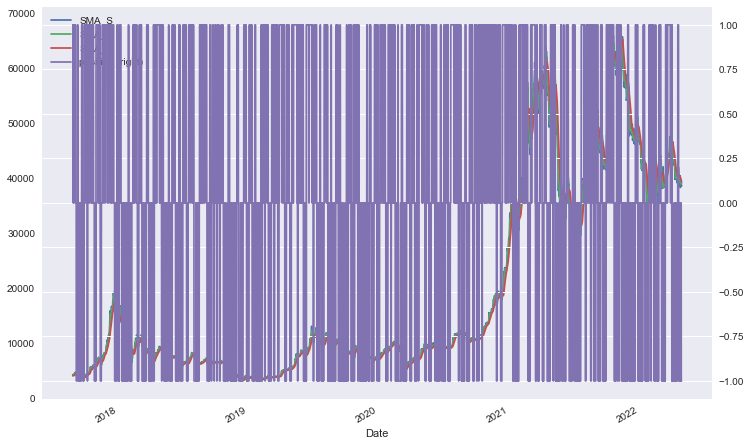

In [46]:
#visualizing the nr. of times the model takes a long or short position
data.loc[:, smas + ["position"]].plot(figsize = (12, 8), secondary_y = "position")
plt.show()

## 3) Backtesting

In this section I backtest the performance of the strategy. To do the backtesting I will be using a previously developed framework and adjusting the inputs for this strategy.

In [57]:
class Long_Short_Backtester():
    ''' Class for the vectorized backtesting of simple Long-Short trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum).
         
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Long_Short_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        self.data = raw
        
    def test_strategy(self, smas):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        smas: tuple (SMA_S, SMA_M, SMA_L)
            Simple Moving Averages to be considered for the strategy.
            
        '''
        
        self.SMA_S = smas[0]
        self.SMA_M = smas[1]
        self.SMA_L = smas[2]
        
        
        self.prepare_data(smas = smas)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, smas):
        ''' Prepares the Data for Backtesting.
        '''
        ########################## Strategy-Specific #############################
        
        data = self.data[["Close", "returns"]].copy()
        data["SMA_S"] = data.Close.rolling(window = smas[0]).mean()
        data["SMA_M"] = data.Close.rolling(window = smas[1]).mean()
        data["SMA_L"] = data.Close.rolling(window = smas[2]).mean()
        
        data.dropna(inplace = True)
                
        cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
        cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)
        
        data["position"] = 0
        data.loc[cond1, "position"] = 1
        data.loc[cond2, "position"] = -1

        ##########################################################################
        
        self.results = data
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, SMA_S_range, SMA_M_range, SMA_L_range, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        SMA_S_range: tuple
            tuples of the form (start, end, step size).
        
        SMA_M_range: tuple
            tuples of the form (start, end, step size).
            
        SMA_L_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        SMA_S_range = range(*SMA_S_range)
        SMA_M_range = range(*SMA_M_range)
        SMA_L_range = range(*SMA_L_range)
        
        combinations = list(product(SMA_S_range, SMA_M_range, SMA_L_range))
         
        performance = []
        for comb in combinations:
            self.prepare_data(smas = comb)
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["SMA_S", "SMA_M", "SMA_L"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''
        
        best = self.results_overview.nlargest(1, "performance")
        SMA_S = best.SMA_S.iloc[0]
        SMA_M = best.SMA_M.iloc[0]
        SMA_L = best.SMA_L.iloc[0]
        perf = best.performance.iloc[0]
        print("SMA_S: {} | SMA_M: {} | SMA_L : {} | {}: {}".format(SMA_S, SMA_M, SMA_L, self.metric, round(perf, 5)))  
        self.test_strategy(smas = (SMA_S, SMA_M, SMA_L))
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
       
        print(100 * "=")
        print("TRIPLE SMA STRATEGY | INSTRUMENT = {} | SMAs = {}".format(self.symbol, [self.SMA_S, self.SMA_M, self.SMA_L]))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)

In [58]:
filepath = "Bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2022-04-07"
tc = -0.00085
sma_s = 15 
sma_m = 50 
sma_l = 200 

In [59]:
tester = Long_Short_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)

In [60]:
tester.data

,Open,High,Low,Close,Volume,returns
Date,,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,NaN
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,0.001505
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,0.002090
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249,0.005912
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807,0.002457
...,...,...,...,...,...,...
2022-04-07 19:00:00,43702.96,43772.52,43375.36,43388.92,1261.654360,-0.007211
2022-04-07 20:00:00,43388.93,43600.06,43376.23,43567.36,714.680540,0.004104
2022-04-07 21:00:00,43567.35,43596.30,43208.00,43520.07,954.309790,-0.001086


In [61]:
tester.test_strategy(smas = (sma_s, sma_m, sma_l))
#testing if the strategy managed to outperform 'buy and hold'

TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [15, 50, 200]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         13.045964
Multiple (Buy-and-Hold):     10.069742
--------------------------------------
Out-/Underperformance:       2.976222


CAGR:                        0.74443
Annualized Mean:             0.556545
Annualized Std:              0.711057
Sharpe Ratio:                1.046933


## 3) Comparison with "buy and hold" strategy

In the period 17/08/2017 - 07/04/2022 the triple SMA managed to outperform a buy and hold strategy, neting 13 USD for every 1 USD invested, while buy and hold managed to net 10 USD for every 1 USD invested.

The compounded annual growth rate for the triple SMA strategy stands at staggering 74%, with an annualized mean of 56% and standard deviation of 71%.

While the returns look very atractive one has to take in mind the high volatility that the asset possesses, leaving it at a Sharpe risk adjusted return ratio of 1.05 which is not that great.

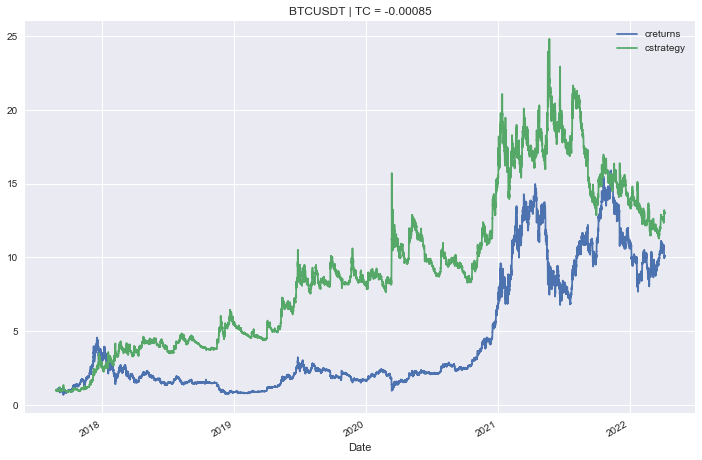

In [62]:
#performance visualization
tester.plot_results()

In [63]:
tester.results

,Close,returns,SMA_S,SMA_M,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,
2017-08-25 11:00:00,4361.27,0.010821,4319.996000,4214.2724,4132.71175,1,NaN,0.0,1.010880,NaN
2017-08-25 12:00:00,4309.69,-0.011897,4326.842000,4215.9058,4132.71605,1,-0.011897,0.0,0.998925,0.988173
2017-08-25 13:00:00,4312.00,0.000536,4325.893333,4217.3860,4132.69945,1,0.000536,0.0,0.999460,0.988703
2017-08-25 14:00:00,4305.00,-0.001625,4325.159333,4219.1724,4132.60270,1,-0.001625,0.0,0.997837,0.987098
2017-08-25 15:00:00,4394.36,0.020545,4327.050000,4222.8396,4132.82455,1,0.020545,0.0,1.018550,1.007587
...,...,...,...,...,...,...,...,...,...,...
2022-04-07 19:00:00,43388.92,-0.007211,43506.242000,44272.4302,45801.60915,-1,0.007211,0.0,10.056931,13.062582
2022-04-07 20:00:00,43567.36,0.004104,43517.400000,44225.9166,45782.97105,-1,-0.004104,0.0,10.098291,13.009081
2022-04-07 21:00:00,43520.07,-0.001086,43526.675333,44175.6680,45765.65140,-1,0.001086,0.0,10.087330,13.023217


In [64]:
tester.results.trades.value_counts()
# The number of positions the strategy executed

0.0    39126
1.0     1224
2.0        1
Name: trades, dtype: int64

## 4) Optimization

While the strategy managed to outperform buy and hold with random SMA legths, there is a lot of room to optimise the SMA's length parameters to achieve the best performance based on historical data. To arrive at the optimal inputs that generate the best performance, I will be using the previously defined backtesting and optimization object.

In [65]:
tester.optimize_strategy(SMA_S_range = (50, 300, 20), 
                         SMA_M_range = (500, 1500, 30),
                         SMA_L_range = (2000, 5000, 100),
                         metric = "Multiple")

#here I input the range to be optimized for the parameters, based on the range selected this process can take some time

SMA_S: 170 | SMA_M: 1010 | SMA_L : 2400 | Multiple: 28.50902
TRIPLE SMA STRATEGY | INSTRUMENT = BTCUSDT | SMAs = [170, 1010, 2400]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         28.509021
Multiple (Buy-and-Hold):     5.181927
--------------------------------------
Out-/Underperformance:       23.327094


CAGR:                        1.154743
Annualized Mean:             0.767797
Annualized Std:              0.690705
Sharpe Ratio:                1.671832


### Description of optimized results

In the period 17/08/2017 - 07/04/2022 the triple SMA strategy managed to outperform a buy and hold strategy by 5 times; with the optimal sma_s: 170, sma_m: 1010 and sma_l: 2400

The compounded annual growth rate for the optimized triple SMA strategy has increased to 115.5%

Most importantly, with the optimized inputs the strategy managed to decrease the volatility while increasing the CAGR which generated a Sharpe Ratio of 1.67

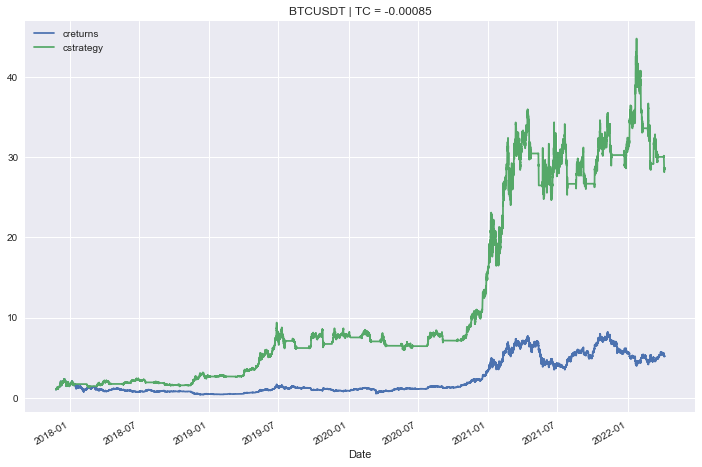

In [66]:
# visualization of the results
tester.plot_results()

In [67]:
tester.results_overview

,SMA_S,SMA_M,SMA_L,performance
0,50,500,2000,12.045764
1,50,500,2100,11.716657
2,50,500,2200,11.601368
3,50,500,2300,10.452793
4,50,500,2400,9.905118
...,...,...,...,...
13255,290,1490,4500,3.950923
13256,290,1490,4600,3.775520
13257,290,1490,4700,3.991380
13258,290,1490,4800,3.409172


## Implementation of the strategy using Binance API

In this section I implement the triple SMA strategy with the Binance API. To execute the strategy I will be using a framework: object LongShortTrader.

#### Note: as of 07/04/2022 Python 3.9 or 3.10 does not work with the threadedwebsocketmanager and you will need to create a seperate Python 3.8 environment for this purpose.

In [ ]:
# Please use testnet api_keys to run the strategy.
api_key = "insert here"
secret_key = "insert here"

In [69]:
client = Client(api_key = api_key, api_secret = secret_key, tld = "com", testnet = True)

In [70]:
class LongShortTrader():
    
    def __init__(self, symbol, bar_length, sma_s, sma_m, sma_l, units, position = 0):
        
        self.symbol = symbol
        self.bar_length = bar_length
        self.available_intervals = ["1m", "3m", "5m", "15m", "30m", "1h", "2h", "4h", "6h", "8h", "12h", "1d", "3d", "1w", "1M"]
        self.units = units
        self.position = position
        self.trades = 0 
        self.trade_values = []
        
        #*****************add strategy-specific attributes here******************
        self.SMA_S = sma_s
        self.SMA_M = sma_m
        self.SMA_L = sma_l
        #************************************************************************
    
    def start_trading(self, historical_days):
        
        self.twm = ThreadedWebsocketManager()
        self.twm.start()
        
        if self.bar_length in self.available_intervals:
            self.get_most_recent(symbol = self.symbol, interval = self.bar_length,
                                 days = historical_days)
            self.twm.start_kline_socket(callback = self.stream_candles,
                                        symbol = self.symbol, interval = self.bar_length)
        # "else" to be added later in the course 
    
    def get_most_recent(self, symbol, interval, days):
    
        now = datetime.utcnow()
        past = str(now - timedelta(days = days))
    
        bars = client.get_historical_klines(symbol = symbol, interval = interval,
                                            start_str = past, end_str = None, limit = 1000)
        df = pd.DataFrame(bars)
        df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
        df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                      "Clos Time", "Quote Asset Volume", "Number of Trades",
                      "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
        df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
        df.set_index("Date", inplace = True)
        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors = "coerce")
        df["Complete"] = [True for row in range(len(df)-1)] + [False]
        
        self.data = df
    
    def stream_candles(self, msg):
        
        # extract the required items from msg
        event_time = pd.to_datetime(msg["E"], unit = "ms")
        start_time = pd.to_datetime(msg["k"]["t"], unit = "ms")
        first   = float(msg["k"]["o"])
        high    = float(msg["k"]["h"])
        low     = float(msg["k"]["l"])
        close   = float(msg["k"]["c"])
        volume  = float(msg["k"]["v"])
        complete=       msg["k"]["x"]
    
        # stop trading session
        if self.trades >= 5: # stop stream after 5 trades
            self.twm.stop()
            if self.position == 1:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL AND STOP")
                self.position = 0
            elif self.position == -1:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL AND STOP")
                self.position = 0
            else: 
                print("STOP")
        
        # print out
        print(".", end = "", flush = True) # just print something to get a feedback (everything OK) 
    
        # feed df (add new bar / update latest bar)
        self.data.loc[start_time] = [first, high, low, close, volume, complete]
        
        # prepare features and define strategy/trading positions whenever the latest bar is complete
        if complete == True:
            self.define_strategy()
            self.execute_trades()
        
    def define_strategy(self):
        
        data = self.data.copy()
        
        #******************** define your strategy here ************************
        data = data[["Close"]].copy()
        
        data["SMA_S"] = data.Close.rolling(window = self.SMA_S).mean()
        data["SMA_M"] = data.Close.rolling(window = self.SMA_M).mean()
        data["SMA_L"] = data.Close.rolling(window = self.SMA_L).mean()
        
        data.dropna(inplace = True)
                
        cond1 = (data.SMA_S > data.SMA_M) & (data.SMA_M > data.SMA_L)
        cond2 = (data.SMA_S < data.SMA_M) & (data.SMA_M < data.SMA_L)
        
        data["position"] = 0
        data.loc[cond1, "position"] = 1
        data.loc[cond2, "position"] = -1
        #***********************************************************************
        
        self.prepared_data = data.copy()
    
    def execute_trades(self): 
        if self.prepared_data["position"].iloc[-1] == 1: # if position is long -> go/stay long
            if self.position == 0:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING LONG")  
            elif self.position == -1:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL")
                time.sleep(1)
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING LONG")
            self.position = 1
        elif self.prepared_data["position"].iloc[-1] == 0: # if position is neutral -> go/stay neutral
            if self.position == 1:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL") 
            elif self.position == -1:
                order = client.create_order(symbol = self.symbol, side = "BUY", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL") 
            self.position = 0
        if self.prepared_data["position"].iloc[-1] == -1: # if position is short -> go/stay short
            if self.position == 0:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING SHORT") 
            elif self.position == 1:
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING NEUTRAL")
                time.sleep(1)
                order = client.create_order(symbol = self.symbol, side = "SELL", type = "MARKET", quantity = self.units)
                self.report_trade(order, "GOING SHORT")
            self.position = -1
    
    def report_trade(self, order, going): 
        
        # extract data from order object
        side = order["side"]
        time = pd.to_datetime(order["transactTime"], unit = "ms")
        base_units = float(order["executedQty"])
        quote_units = float(order["cummulativeQuoteQty"])
        price = round(quote_units / base_units, 5)
        
        # calculate trading profits
        self.trades += 1
        if side == "BUY":
            self.trade_values.append(-quote_units)
        elif side == "SELL":
            self.trade_values.append(quote_units) 
        
        if self.trades % 2 == 0:
            real_profit = round(np.sum(self.trade_values[-2:]), 3) 
            self.cum_profits = round(np.sum(self.trade_values), 3)
        else: 
            real_profit = 0
            self.cum_profits = round(np.sum(self.trade_values[:-1]), 3)
        
        # print trade report
        print(2 * "\n" + 100* "-")
        print("{} | {}".format(time, going)) 
        print("{} | Base_Units = {} | Quote_Units = {} | Price = {} ".format(time, base_units, quote_units, price))
        print("{} | Profit = {} | CumProfits = {} ".format(time, real_profit, self.cum_profits))
        print(100 * "-" + "\n")

In [71]:
symbol = "BTCUSDT"
bar_length = "1m"
sma_s = 10
sma_m = 20
sma_l = 50
units = 0.001
position = 0

In [72]:
client.get_account()

{'makerCommission': 0,
 'takerCommission': 0,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': False,
 'canDeposit': False,
 'updateTime': 1649234296436,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BNB',
   'free': '1000.00000000',
   'locked': '0.00000000'},
  {'asset': 'BTC', 'free': '1.00000000', 'locked': '0.00000000'},
  {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'},
  {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}],
 'permissions': ['SPOT']}

In [73]:
trader = LongShortTrader(symbol = symbol, bar_length = bar_length, sma_s = sma_s, sma_m = sma_m, sma_l = sma_l,
                         units = units, position = position)

In [74]:
trader.start_trading(historical_days = 1/24)

error: bad escape \d at position 7

In [75]:
trader.twm.stop()

In [77]:
trader.prepared_data

AttributeError: 'LongShortTrader' object has no attribute 'prepare_data'